In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

## 1. Import claims_data.csv and cust_data.csv which is provided to you and combine the two datasets appropriately to create a 360-degree view of the data. Use the same for the subsequent questions.

In [ ]:
claims = pd.read_csv(r'claims.csv')

In [ ]:
cust_demo = pd.read_csv(r'cust_demographics.csv')
cust_demo

,CUST_ID,gender,DateOfBirth,State,Contact,Segment
0,21868593,Female,12-Jan-79,VT,789-916-8172,Platinum
1,75740424,Female,13-Jan-70,ME,265-543-1264,Silver
2,30308357,Female,11-Mar-84,TN,798-631-4758,Silver
3,47830476,Female,1-May-86,MA,413-187-7945,Silver
4,19269962,Male,13-May-77,NV,956-871-8691,Gold
...,...,...,...,...,...,...
1080,79539873,Female,15-Mar-81,ND,459-425-4319,Platinum
1081,42364152,Female,7-Jul-96,ID,529-462-1635,Silver
1082,19888166,Male,11-Apr-90,WI,712-651-9613,Gold
1083,11256802,Female,22-Oct-64,LA,469-345-5617,Silver


In [ ]:
data360 = pd.merge(left= claims, right= cust_demo, left_on= 'customer_id', right_on= 'CUST_ID', how= 'left')

In [ ]:
data360.isna().sum()

claim_id                0
customer_id             0
incident_cause          0
claim_date              0
claim_area              0
police_report           0
claim_type              0
claim_amount           65
total_policy_claims    10
fraudulent              0
CUST_ID                15
gender                 15
DateOfBirth            15
State                  15
Contact                15
Segment                15
dtype: int64

In [ ]:
data360.CUST_ID[data360.CUST_ID.isna()] = 0

<ipython-input-817-eb1a260e9d5c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data360.CUST_ID[data360.CUST_ID.isna()] = 0


In [ ]:
data360.drop(columns= 'customer_id', inplace= True)

In [ ]:
data360.isna().sum()

claim_id                0
incident_cause          0
claim_date              0
claim_area              0
police_report           0
claim_type              0
claim_amount           65
total_policy_claims    10
fraudulent              0
CUST_ID                 0
gender                 15
DateOfBirth            15
State                  15
Contact                15
Segment                15
dtype: int64

In [ ]:
data360.total_policy_claims = data360.total_policy_claims.fillna(0)

In [ ]:
data360.total_policy_claims.isnull().sum()

0

## 2. Perform a data audit for the datatypes and find out if there are any mismatch within the current datatypes of the columns and their business significance.

In [ ]:
data360.claim_date = pd.to_datetime(data360.claim_date, format = "%m/%d/%Y")

In [ ]:
data360.DateOfBirth = pd.to_datetime(data360.DateOfBirth, format = "%d-%b-%y")

In [ ]:
data360.loc[(data360.DateOfBirth.dt.year > 2020),"DateOfBirth"]=data360[data360.DateOfBirth.dt.year > 2020]["DateOfBirth"].apply(lambda x: x - pd.DateOffset(years=100))

In [ ]:
data360.CUST_ID = data360.CUST_ID.astype('int64')

In [ ]:
data360.dtypes

claim_id                        int64
customer_id                     int64
incident_cause                 object
claim_date             datetime64[ns]
claim_area                     object
police_report                  object
claim_type                     object
claim_amount                   object
total_policy_claims           float64
fraudulent                     object
CUST_ID                         int64
gender                         object
DateOfBirth            datetime64[ns]
State                          object
Contact                        object
Segment                        object
dtype: object

## 3. Convert the column claim_amount to numeric. Use the appropriate modules/attributes to remove the $ sign.

In [ ]:
data360.claim_amount = data360.claim_amount.astype(str).apply(lambda x : x.replace('$','').replace(',','')).astype('float')

## 4. Of all the injury claims, some of them have gone unreported with the police. Create an alert flag (1,0) for all such claims.

In [ ]:
data360['flag'] = np.where(data360.police_report == 'No', 0,
                 np.where(data360.police_report == 'Yes', 1, np.nan))

In [ ]:
data360.drop(columns= 'police_report', inplace= True)

In [ ]:
data360.head(5)

,claim_id,incident_cause,claim_date,claim_area,claim_type,claim_amount,total_policy_claims,fraudulent,CUST_ID,gender,DateOfBirth,State,Contact,Segment,flag
0,54004764,Driver error,2017-11-27,Auto,Material only,2980.0,1.0,No,21868593,Female,1979-01-12,VT,789-916-8172,Platinum,0.0
1,33985796,Crime,2018-10-03,Home,Material only,2980.0,3.0,No,75740424,Female,1970-01-13,ME,265-543-1264,Silver,NaN
2,53522022,Other driver error,2018-02-02,Auto,Material only,3369.5,1.0,Yes,30308357,Female,1984-03-11,TN,798-631-4758,Silver,0.0
3,13015401,Natural causes,2018-06-17,Auto,Material only,1680.0,1.0,No,47830476,Female,1986-05-01,MA,413-187-7945,Silver,0.0
4,22890252,Crime,2018-01-13,Auto,Material only,2680.0,1.0,No,19269962,Male,1977-05-13,NV,956-871-8691,Gold,0.0


## 5. One customer can claim for insurance more than once and in each claim, multiple categories of claims can be involved. However, customer ID should remain unique. Retain the most recent observation and delete any duplicated records in the data based on the customer ID column.

In [ ]:
data360.groupby('CUST_ID').first().reset_index()

,CUST_ID,claim_id,incident_cause,claim_date,claim_area,claim_type,claim_amount,total_policy_claims,fraudulent,gender,DateOfBirth,State,Contact,Segment,flag
0,0,5829074,Other causes,2018-07-20,Auto,Material only,2080.0,1.0,No,None,NaT,None,None,None,0.0
1,154557,69348631,Driver error,2018-04-10,Auto,Injury only,NaN,1.0,Yes,Female,1978-05-23,DE,962-879-1238,Platinum,0.0
2,263204,40953049,Other causes,2018-04-04,Auto,Material and injury,39192.0,1.0,Yes,Male,1972-12-20,TX,173-892-6314,Silver,0.0
3,287476,45780237,Natural causes,2017-10-17,Auto,Material only,1621.5,2.0,Yes,Male,1988-07-28,FL,364-598-1549,Silver,NaN
4,441097,89833962,Other causes,2018-03-21,Auto,Material and injury,37040.0,1.0,No,Male,1971-08-19,CA,187-348-8375,Gold,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,99674324,4549014,Other causes,2018-07-07,Auto,Injury only,21480.0,1.0,No,Male,1965-01-28,UT,517-562-4916,Silver,0.0
1075,99723844,35453672,Natural causes,2018-01-06,Auto,Material and injury,14360.0,1.0,No,Female,1966-06-19,HI,457-752-1374,Gold,1.0
1076,99761663,37305754,Natural causes,2018-04-04,Auto,Material only,1242.0,1.0,Yes,Female,1963-11-18,NC,643-246-4718,Silver,0.0
1077,99892000,22960702,Driver error,2017-11-13,Auto,Material only,2415.0,2.0,Yes,Male,1995-06-08,OR,395-246-6172,Gold,0.0


In [ ]:
data360.groupby('CUST_ID').first().reset_index() == 84147585

,CUST_ID,claim_id,incident_cause,claim_date,claim_area,claim_type,claim_amount,total_policy_claims,fraudulent,gender,DateOfBirth,State,Contact,Segment,flag,Age,Age_Grp
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1075,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1076,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1077,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


## 6. Check for missing values and impute the missing values with an appropriate value. (mean for continuous and mode for categorical)

In [ ]:
data360.dtypes

claim_id                        int64
incident_cause                 object
claim_date             datetime64[ns]
claim_area                     object
claim_type                     object
claim_amount                  float64
total_policy_claims           float64
fraudulent                     object
CUST_ID                         int64
gender                         object
DateOfBirth            datetime64[ns]
State                          object
Contact                        object
Segment                        object
flag                          float64
dtype: object

In [ ]:
cat_col = ['incident_cause', 'claim_area', 'claim_type','fraudulent','gender','State','Segment']
con_col = ['claim_amount']

In [ ]:
for i in cat_col:
    data360[i] = data360[i].fillna(data360[i].mode()[0])

In [ ]:
data360[con_col] = data360[con_col].fillna(data360[con_col].mean())

In [ ]:
data360.isnull().sum()

claim_id                 0
incident_cause           0
claim_date               0
claim_area               0
claim_type               0
claim_amount             0
total_policy_claims     10
fraudulent               0
CUST_ID                  0
gender                   0
DateOfBirth             15
State                    0
Contact                 15
Segment                  0
flag                   300
dtype: int64

## 7. Calculate the age of customers in years. Based on the age, categorize the customers according to the below criteria
### Children < 18
### Youth 18-30
### Adult 30-60
### Senior > 60

In [ ]:
data360['Age'] = data360.claim_date.dt.year - data360.DateOfBirth.dt.year

In [ ]:
data360['Age_Grp'] = np.where(data360.Age < 18, 'Children',
                    np.where((data360.Age >= 18) & (data360.Age < 30), 'Youth',
                    np.where((data360.Age >= 30) & (data360.Age < 60), 'Adult','Senior')))

## 8. What is the average amount claimed by the customers from various segments?

In [ ]:
data360.groupby(['Segment'])[['claim_amount']].mean()

,claim_amount
Segment,
Gold,12746.446802
Platinum,12340.893306
Silver,12206.379320


## 9. What is the total claim amount based on incident cause for all the claims that have been done at least 20 days prior to 1st of October, 2018.

In [ ]:
data360.loc[data360.claim_date < '2018-09-10',:].groupby('incident_cause')[['claim_amount']].sum().add_prefix('total_').reset_index()

,incident_cause,total_claim_amount
0,Crime,7.294726e+05
1,Driver error,3.348656e+06
2,Natural causes,1.316441e+06
3,Other causes,3.779869e+06
4,Other driver error,3.384045e+06


## 10. How many adults from TX, DE and AK claimed insurance for driver related issues and causes?

In [ ]:
data360.loc[((data360.incident_cause.str.lower().str.contains("driver")) & ((data360.State == "TX") | (data360.State == "DE") | (data360.State == "AK"))),:].groupby(data360.Age_Grp[data360.Age_Grp == 'Adult'])['State'].count()

Age_Grp
Adult    25
Name: State, dtype: int64

## 11. Draw a pie chart between the aggregated value of claim amount based on gender and segment. Represent the claim amount as a percentage on the pie chart.

In [ ]:
res = pd.crosstab(index= data360.gender, columns = data360.Segment, values = data360.claim_amount, aggfunc= 'sum' )
res

Segment,Gold,Platinum,Silver
gender,,,
Female,2.109508e+06,2.369305e+06,1.901580e+06
Male,2.861606e+06,2.098099e+06,2.346240e+06


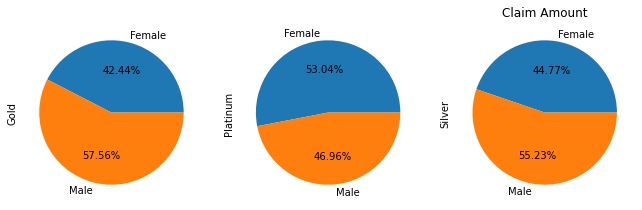

In [ ]:
res.plot(kind = 'pie', autopct='%.2f%%', subplots = True, legend = False, figsize = (11,8))
plt.title('Claim Amount')
plt.show()

In [ ]:
res1 = data360.groupby([data360.gender,data360.Segment])[['claim_amount']].sum()

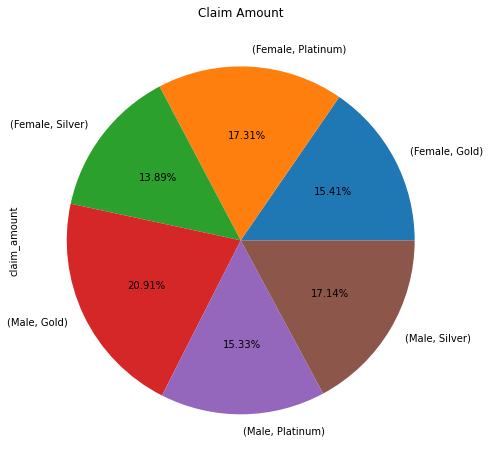

In [ ]:
res1.plot(kind = 'pie', autopct='%.2f%%', subplots = True, legend = False, figsize = (11,8))
plt.title('Claim Amount')
plt.show()

In [ ]:
plt.pie(res)

## 12. Among males and females, which gender had claimed the most for any type of driver related issues? E.g. This metric can be compared using a bar chart

In [ ]:
gender_driver_ins = data360.loc[(data360.incident_cause.str.lower().str.contains('driver'))].groupby('gender')[['gender']].count().add_prefix('count_of_').reset_index()
gender_driver_ins

,gender,count_of_gender
0,Female,222
1,Male,289


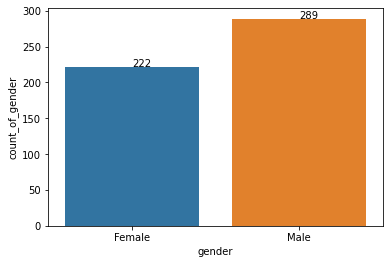

In [ ]:
sns.barplot(x = 'gender', y= 'count_of_gender', data = gender_driver_ins)
plt.text(x = 0, y = 222, s = '222')
plt.text(x = 1, y = 289, s = '289')
plt.show()

## 13. Which age group had the maximum fraudulent policy claims? Visualize it on a bar chart.

USe Subplots

In [ ]:
data360[(data360.Age_Grp == np.nan)]

,claim_id,incident_cause,claim_date,claim_area,claim_type,claim_amount,total_policy_claims,fraudulent,CUST_ID,gender,DateOfBirth,State,Contact,Segment,flag,Age,Age_Grp


In [ ]:
val = data360['Age_Grp'].mode()[0]
print(val)
data360.loc[:,"Age_Grp"] = data360.loc[:,'Age_Grp'].fillna(value = val)

Adult


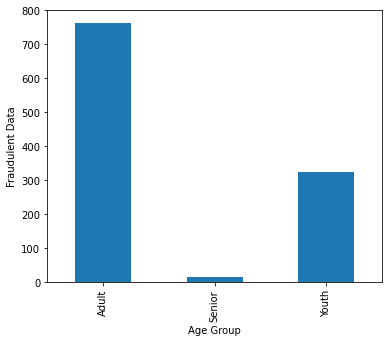

In [ ]:
grp_data = data360.groupby(by = "Age_Grp")[["fraudulent"]].count()
grp_data.plot(kind = 'bar',figsize = (6,5), legend = False, width = 0.5)
plt.xlabel('Age Group')
plt.ylabel('Fraudulent Data')
plt.show()

## 14. Visualize the monthly trend of the total amount that has been claimed by the customers. Ensure that on the “month” axis, the month is in a chronological order not alphabetical order.

In [ ]:
months = data360.groupby([data360.claim_date.dt.month, data360.claim_date.dt.strftime('%B')])[['claim_amount']].sum().reset_index(level= 0)

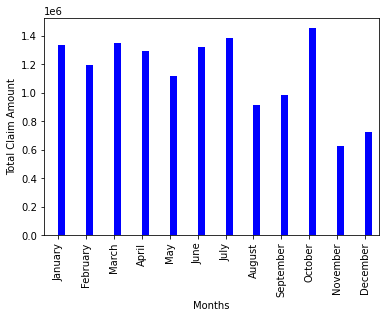

In [ ]:
months.plot(kind = 'bar', legend = False, color = 'b')
plt.xlabel('Months')
plt.ylabel('Total Claim Amount')
plt.show()

## 15. What is the average claim amount for gender and age categories and suitably represent the above using a facetted bar chart, one facet that represents fraudulent claims and the other for non-fraudulent claims.

In [ ]:
mean_amt = data360.groupby(['gender','Age_Grp', 'fraudulent'])['claim_amount'].mean().reset_index()

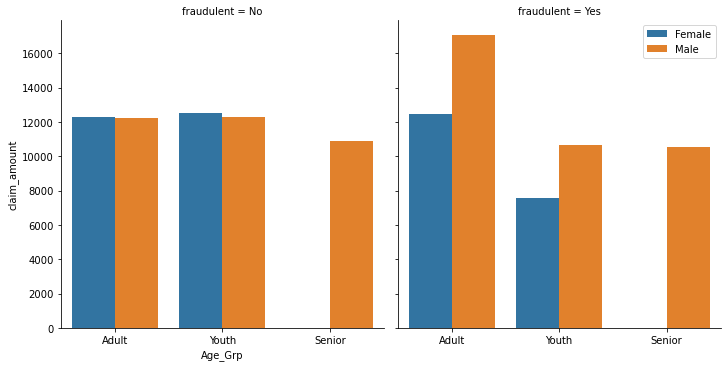

In [ ]:
sns.catplot(x = "Age_Grp", y = "claim_amount", hue = "gender",col = 'fraudulent', data = mean_amt, kind="bar", legend= False)
plt.legend(loc="upper right")
plt.xlabel('')
plt.show()

# Based on the conclusions from exploratory analysis as well as suitable
# statistical tests, answer the below questions. Please include a detailed
# write-up on the parameters taken into consideration, the Hypothesis
# testing steps, conclusion from the p-values and the business implications of
# the statements.

## 16. Is there any similarity in the amount claimed by males and females?

In [ ]:
f_amt = data360.claim_amount[data360.gender == 'Female']
m_amt = data360.claim_amount[data360.gender == 'Male']

In [ ]:
f_amt.mean()

12061.233702272999

In [ ]:
m_amt.mean()

12795.000007614408

In [ ]:
stats.ttest_ind(f_amt,m_amt)

Ttest_indResult(statistic=-0.910525219359747, pvalue=0.3627454254155197)

In [ ]:
# As pvalue >0.05 so we cannot reject null value hypothesis. So, with 95% CI amount claimed by males and females are different from each other.

## 17. Is there any relationship between age category and segment?

In [ ]:
ct = pd.crosstab(data360.Age_Grp,data360.Segment)

In [ ]:
print(stats.chi2_contingency(ct))

(29.469017003677166, 6.276787783476251e-06, 4, array([[270.16363636, 250.76727273, 241.06909091],
       [  5.31818182,   4.93636364,   4.74545455],
       [114.51818182, 106.29636364, 102.18545455]]))


In [ ]:
# As pvalue < 0.05, therefore with 95% CI there is a relationship between age category and segment

## 18. The current year has shown a significant rise in claim amounts as compared to 2016-17 fiscal average which was $10,000.

In [ ]:
stats.ttest_1samp(data360.claim_amount, popmean = 10000)

Ttest_1sampResult(statistic=6.065724749109332, pvalue=1.8045108162850086e-09)

In [ ]:
# we can reject the nul hypothesis as the pvalue < 0.05. So, the current year has shown a significant rise in claim amount than $10,000

## 19. Is there any difference between age groups and insurance claims?

In [ ]:
data360.Age_Grp.value_counts()

Adult     762
Youth     323
Senior     15
Name: Age_Grp, dtype: int64

In [ ]:
a_claims = data360.total_policy_claims[data360.Age_Grp == 'Adult']
y_claims = data360.total_policy_claims[data360.Age_Grp == 'Youth']
s_claims = data360.total_policy_claims[data360.Age_Grp == 'Senior']

In [ ]:
print(a_claims.mean())
print(y_claims.mean())
print(s_claims.mean())

1.5564304461942258
1.609907120743034
1.9333333333333333


In [ ]:
stats.f_oneway(a_claims,y_claims,s_claims)

F_onewayResult(statistic=0.9707821785969832, pvalue=0.379111809977035)

In [ ]:
# As pvalue > 0.05. so, with 95% CI there is no difference between age groups and insurance claim amount

## 20. Is there any relationship between total number of policy claims and the claimed amount?

In [ ]:
stats.pearsonr(data360.total_policy_claims,data360.claim_amount)

(-0.02073942645947518, 0.4919940008936198)

In [ ]:
# As pvalue > 0.05, therefore with 95% CI there is negative relationship between total number of Policy Claims and the claimed amount